# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [13]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

train_stats

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.766531,670.078990,318.978827,175.550081,5.289902,3.454397,0.232248,2.824104,22.500384,24.788550
std,0.107937,89.758475,41.746228,45.243681,1.750971,1.122383,0.132343,1.554346,10.100263,9.536716
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.070000,10.900000
25%,0.660000,588.000000,294.000000,122.500000,3.500000,2.000000,0.100000,1.000000,13.000000,15.737500
50%,0.760000,661.500000,318.500000,147.000000,7.000000,3.000000,0.250000,3.000000,19.450000,24.190000
75%,0.860000,759.500000,343.000000,220.500000,7.000000,4.000000,0.400000,4.000000,31.832500,33.167500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,42.960000,48.030000


In [14]:
# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
X1,614.0,0.766531,0.107937,0.62,0.66,0.76,0.86,0.98
X2,614.0,670.078990,89.758475,514.50,588.00,661.50,759.50,808.50
X3,614.0,318.978827,41.746228,245.00,294.00,318.50,343.00,416.50
X4,614.0,175.550081,45.243681,110.25,122.50,147.00,220.50,220.50
X5,614.0,5.289902,1.750971,3.50,3.50,7.00,7.00,7.00
X6,614.0,3.454397,1.122383,2.00,2.00,3.00,4.00,5.00
X7,614.0,0.232248,0.132343,0.00,0.10,0.25,0.40,0.40
X8,614.0,2.824104,1.554346,0.00,1.00,3.00,4.00,5.00


In [15]:
train

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
605,0.90,563.5,318.5,122.50,7.0,4,0.40,4,35.40,39.22
413,0.69,735.0,294.0,220.50,3.5,4,0.10,3,11.10,14.67
209,0.86,588.0,294.0,147.00,7.0,2,0.40,5,32.31,29.69
693,0.90,563.5,318.5,122.50,7.0,2,0.25,4,32.67,32.12
195,0.66,759.5,318.5,220.50,3.5,3,0.40,5,14.92,17.79
...,...,...,...,...,...,...,...,...,...,...
455,0.66,759.5,318.5,220.50,3.5,5,0.25,1,13.18,16.19
757,0.62,808.5,367.5,220.50,3.5,5,0.40,5,16.64,16.03
450,0.98,514.5,294.0,110.25,7.0,4,0.40,5,32.21,33.76
263,0.79,637.0,343.0,147.00,7.0,4,0.25,1,39.86,36.85


In [16]:
test

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
631,0.79,637.0,343.0,147.0,7.0,3,0.10,2,37.26,34.62
300,0.64,784.0,343.0,220.5,3.5,5,0.10,1,15.21,19.32
245,0.82,612.5,318.5,147.0,7.0,5,0.25,3,25.17,26.41
379,0.71,710.5,269.5,220.5,3.5,5,0.25,4,12.28,15.64
159,0.74,686.0,245.0,220.5,3.5,4,0.40,3,14.10,16.57
...,...,...,...,...,...,...,...,...,...,...
500,0.62,808.5,367.5,220.5,3.5,3,0.25,1,15.12,15.95
542,0.86,588.0,294.0,147.0,7.0,2,0.40,1,31.89,35.99
479,0.64,784.0,343.0,220.5,3.5,3,0.40,1,19.36,22.73
285,0.62,808.5,367.5,220.5,3.5,2,0.40,5,16.54,16.88


In [18]:
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [20]:
norm_train_X

,X1,X2,X3,X4,X5,X6,X7,X8
605,1.236544,-1.187398,-0.011470,-1.172541,0.976657,0.486111,1.267558,0.756521
413,-0.709033,0.723286,-0.598349,0.993507,-1.022234,0.486111,-0.999279,0.113164
209,0.865958,-0.914443,-0.598349,-0.631029,0.976657,-1.295812,1.267558,1.399878
693,1.236544,-1.187398,-0.011470,-1.172541,0.976657,-1.295812,0.134140,0.756521
195,-0.986972,0.996240,-0.011470,0.993507,-1.022234,-0.404850,1.267558,1.399878
...,...,...,...,...,...,...,...,...
455,-0.986972,0.996240,-0.011470,0.993507,-1.022234,1.377072,0.134140,-1.173551
757,-1.357558,1.542150,1.162289,0.993507,-1.022234,1.377072,1.267558,1.399878
450,1.977716,-1.733307,-0.598349,-1.443297,0.976657,0.486111,1.267558,1.399878
263,0.217433,-0.368533,0.575409,-0.631029,0.976657,0.486111,0.134140,-1.173551


In [21]:
norm_test_X

,X1,X2,X3,X4,X5,X6,X7,X8
631,0.217433,-0.368533,0.575409,-0.631029,0.976657,-0.404850,-0.999279,-0.530193
300,-1.172265,1.269195,0.575409,0.993507,-1.022234,1.377072,-0.999279,-1.173551
245,0.495372,-0.641488,-0.011470,-0.631029,0.976657,1.377072,0.134140,0.113164
379,-0.523740,0.450331,-1.185229,0.993507,-1.022234,1.377072,0.134140,0.756521
159,-0.245800,0.177376,-1.772108,0.993507,-1.022234,0.486111,1.267558,0.113164
...,...,...,...,...,...,...,...,...
500,-1.357558,1.542150,1.162289,0.993507,-1.022234,-0.404850,0.134140,-1.173551
542,0.865958,-0.914443,-0.598349,-0.631029,0.976657,-1.295812,1.267558,-1.173551
479,-1.172265,1.269195,0.575409,0.993507,-1.022234,-0.404850,1.267558,-1.173551
285,-1.357558,1.542150,1.162289,0.993507,-1.022234,-1.295812,1.267558,1.399878


When you subtract train_stats['mean'] from x, it performs element-wise subtraction between the elements of the two data structures. Since train_stats['mean'] is a Series with 8 elements (one for each feature), and x is a DataFrame with a larger number of elements, the subtraction is performed column-wise, meaning that the corresponding element of train_stats['mean'] is subtracted from each element of the corresponding column in x.

In other words, if you have x with m rows and n columns, and train_stats['mean'] with n elements, the subtraction will produce a new DataFrame with m rows and n columns, where each element of the new DataFrame is the result of subtracting the corresponding element of train_stats['mean'] from the corresponding element in the corresponding column of x.

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 948us/sample - loss: 208.2131 - y1_output_loss: 100.8814 - y2_output_loss: 105.3856 - y1_output_root_mean_squared_error: 10.0905 - y2_output_root_mean_squared_error: 10.3148 - val_loss: 38.7419 - val_y1_output_loss: 15.4510 - val_y2_output_loss: 24.0552 - val_y1_output_root_mean_squared_error: 3.9035 - val_y2_output_root_mean_squared_error: 4.8482
Epoch 2/500
614/614 [==============================] - 0s 145us/sample - loss: 28.9205 - y1_output_loss: 12.0043 - y2_output_loss: 16.9499 - y1_output_root_mean_squared_error: 3.4641 - y2_output_root_mean_squared_error: 4.1135 - val_loss: 39.6890 - val_y1_output_loss: 15.2013 - val_y2_output_loss: 26.4580 - val_y1_output_root_mean_squared_error: 3.8398 - val_y2_output_root_mean_squared_error: 4.9945
Epoch 3/500
614/614 [==============================] - 0s 137us/sample - loss: 28.4259 - y1_output_loss: 10.3950 - y2_output_loss: 17.8028 - y1

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 684us/sample - loss: 0.7700 - y1_output_loss: 0.2296 - y2_output_loss: 0.5341 - y1_output_root_mean_squared_error: 0.4814 - y2_output_root_mean_squared_error: 0.7337
Loss = 0.7700276986345068, Y1_loss = 0.2295961081981659, Y1_mse = 0.48141634464263916, Y2_loss = 0.5340682864189148, Y2_mse = 0.7336661219596863


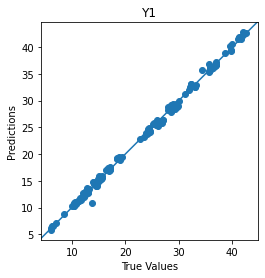

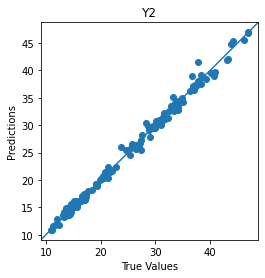

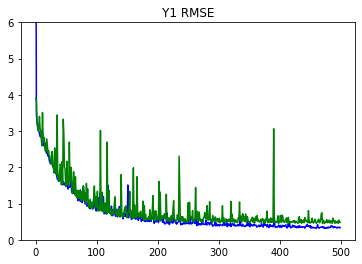

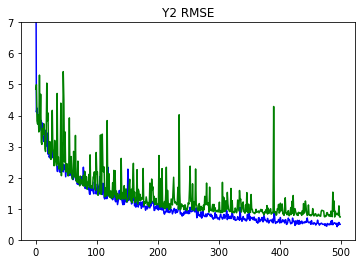

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)